In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
img_left = cv2.imread('left.jpg')
img_right = cv2.imread('right.jpg')

print(f"Image dimensions: {img_left.shape[1]}x{img_left.shape[0]}")

max_dim = 1000

# Resize Images, both have same dimensions
if max(img_left.shape) > max_dim:
    scale_percent_left = max_dim / max(img_left.shape)
    width_left = int(img_left.shape[1] * scale_percent_left)
    height_left = int(img_left.shape[0] * scale_percent_left)
    dim_left = (width_left, height_left)
    img_left = cv2.resize(img_left, dim_left, interpolation = cv2.INTER_AREA)
    img_right = cv2.resize(img_right, dim_left, interpolation = cv2.INTER_AREA)
    print(f"Resized images dimensions: {img_left.shape[1]}x{img_left.shape[0]}")

img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

Image dimensions: 4096x3072
Resized images dimensions: 1000x750


In [3]:
orb = cv2.ORB_create(nfeatures=5000)
kp_left, des_left = orb.detectAndCompute(img_left_gray, None)
kp_right, des_right = orb.detectAndCompute(img_right_gray, None)

if des_left is None or des_right is None:
    print("Error: No features detected in one or both images. Try adjusting nfeatures or image quality.")
print(f"Detected {len(kp_left)} features in left image.")
print(f"Detected {len(kp_right)} features in right image.")

Detected 4842 features in left image.
Detected 4863 features in right image.


In [4]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches = bf.knnMatch(des_left, des_right, k=2)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Number of initial matches: {len(matches)}")
print(f"Number of good matches after ratio test: {len(good_matches)}")

Number of initial matches: 4842
Number of good matches after ratio test: 1771


In [5]:
pts_left = np.float32([kp_left[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts_right = np.float32([kp_right[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
F, mask = cv2.findFundamentalMat(pts_left, pts_right, cv2.FM_RANSAC, 3.0, 0.99)

In [6]:
good_matches_ransac = []
for i in range(len(good_matches)):
    if mask[i] == 1:
        good_matches_ransac.append(good_matches[i])

print(f"Number of good matches after RANSAC: {len(good_matches_ransac)}")
final_matches = good_matches

Number of good matches after RANSAC: 1590


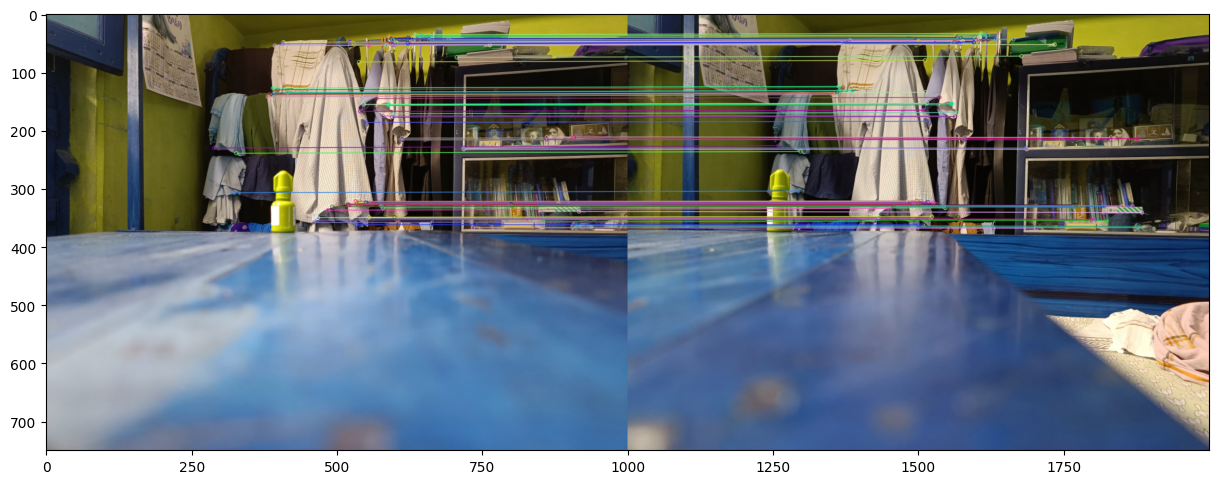

In [7]:
# select best 100 matches
vis_matches = cv2.drawMatches(img_left, kp_left, img_right, kp_right, final_matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15, 10))
plt.imshow(vis_matches)


Number of matches within bounding box (initial): 9
Number of matches within bounding box (after right-side clustering filter): 8


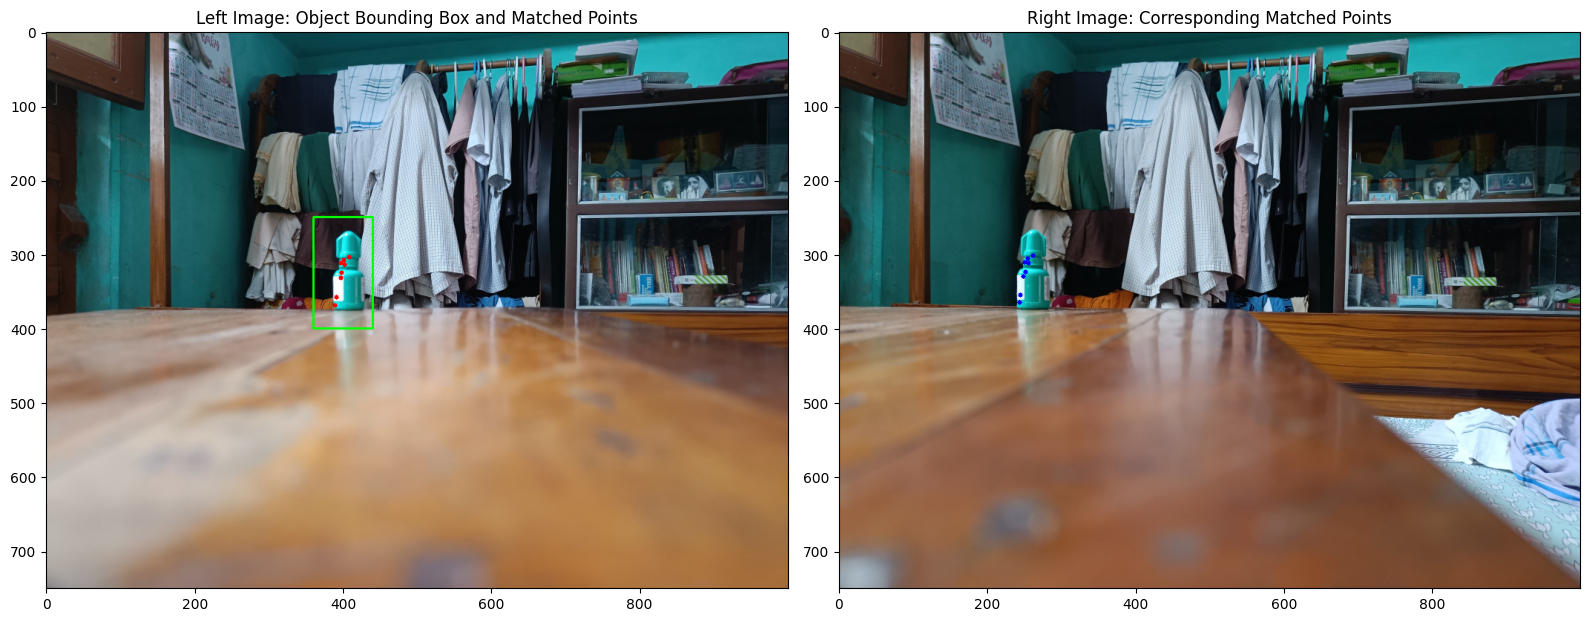

In [46]:
# Create copies of the images to avoid modifying the originals
img_left_with_box = img_left.copy()
img_right_with_box = img_right.copy()


# Draw a bounding box around the object in the left image
x = 360
y = 250
width = 80
height = 150
cv2.rectangle(img_left_with_box, (x, y), (x + width, y + height), (0, 255, 0), 2)


bound_matches = []
# find matches within the bounding box from final_matches, in the left image
# Ensure final_matches, kp_left, and kp_right are defined from previous cells
for match in final_matches:
    left_pt = kp_left[match.queryIdx].pt
    if x <= left_pt[0] <= x + width and y <= left_pt[1] <= y + height:
        bound_matches.append(match)

print(f"Number of matches within bounding box (initial): {len(bound_matches)}")

# since matches should be close enough to each other, we remove certain matches from bound_matches which are not close enough to others in the right image

if len(bound_matches) > 1: # Need at least 2 points to calculate median/cluster
    # Extract right image points (coordinates) for the current bound_matches
    right_pts_in_box = np.float32([kp_right[m.trainIdx].pt for m in bound_matches])

    # Calculate the median of the X and Y coordinates for these right points
    median_right_x = np.median(right_pts_in_box[:, 0])
    median_right_y = np.median(right_pts_in_box[:, 1])

    filtered_bound_matches = []
    # Define a threshold for outlier removal (in pixels).
    # You might need to tune this value based on your object size and camera baseline.
    # Larger threshold keeps more points, smaller threshold is stricter.
    outlier_threshold_pixels = 50 # Example: points more than 40 pixels from the median are removed

    for match in bound_matches:
        right_pt = kp_right[match.trainIdx].pt
        # Calculate Euclidean distance from the current point to the median point
        distance = np.sqrt((right_pt[0] - median_right_x)**2 + (right_pt[1] - median_right_y)**2)
        
        if distance < outlier_threshold_pixels:
            filtered_bound_matches.append(match)

    # Update bound_matches with the filtered list
    bound_matches = filtered_bound_matches
    print(f"Number of matches within bounding box (after right-side clustering filter): {len(bound_matches)}")
else:
    print("Not enough matches in bounding box to perform right-side clustering filter.")


# --- Prepare Left Image for Display ---
# Use img_left_with_box as it already has the bounding box drawn
img_left_display = img_left_with_box.copy()

# Draw the keypoints from bound_matches on the left image
for match in bound_matches:
    point = tuple(map(int, kp_left[match.queryIdx].pt)) # Convert float coordinates to int
    cv2.circle(img_left_display, point, 3, (0, 0, 255), -1) # Red circle, filled

# Convert for matplotlib display
img_left_display_rgb = cv2.cvtColor(img_left_display, cv2.COLOR_BGR2RGB)


# --- Prepare Right Image for Display ---
img_right_display = img_right.copy() # Start with the original right image

# Draw the corresponding keypoints from bound_matches on the right image
for match in bound_matches:
    point = tuple(map(int, kp_right[match.trainIdx].pt)) # Note: using trainIdx for right image
    cv2.circle(img_right_display, point, 3, (255, 0, 0), -1) # Blue circle, filled

# Convert for matplotlib display
img_right_display_rgb = cv2.cvtColor(img_right_display, cv2.COLOR_BGR2RGB)


# --- Display Both Images Side-by-Side using Subplots ---
plt.figure(figsize=(16, 8)) # Adjust overall figure size as needed

# Left Subplot
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.imshow(img_left_display_rgb)
plt.title("Left Image: Object Bounding Box and Matched Points")

# Right Subplot
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.imshow(img_right_display_rgb)
plt.title("Right Image: Corresponding Matched Points")

plt.tight_layout() # Adjust subplot params for a tight layout
plt.show()

In [37]:
# Distance calculation

# Assuming the matches are of the same object in both images
# find median (coordinates) of the matched points
left_mid = np.median([kp_left[m.queryIdx].pt for m in bound_matches], axis=0)
right_mid = np.median([kp_right[m.trainIdx].pt for m in bound_matches], axis=0)

img_mid = (img_left.shape[1]//2, img_left.shape[0]//2)

# subtended angle calculation
h = left_mid[0] - img_mid[0]
b = img_left.shape[0]//2
left_angle = np.arctan2(h, b) * (180 / np.pi)  # Convert radians to degrees
left_angle = np.abs(left_angle)

h = right_mid[0] - img_mid[0]
b = img_right.shape[0]//2
right_angle = np.arctan2(h, b) * (180 / np.pi)  # Convert radians to degrees
right_angle = np.abs(right_angle)

subtended_angle = np.abs(left_angle - right_angle)
arc_len = 9 # Example arc length in cm, put as needed
distance = (arc_len * 180) / (np.pi * subtended_angle)  # Distance in cm
print(f"Subtended angle: {subtended_angle:.2f} degrees")
print(f"Distance to object: {distance:.2f} cm")



Subtended angle: 18.35 degrees
Distance to object: 28.10 cm


In [43]:
# --- ASSUMPTIONS (These values come from your CAMERA CALIBRATION) ---
# For demonstration purposes, I'll use placeholders.
# You will get these from your actual camera calibration results.
f_x_pixels = 700.0  # Example focal length in pixels (fx from camera matrix) # 700 IS FOR MY ONEPLUS NORD 2 MAIN CAMERA
baseline_cm = 9.0   # Example baseline in cm (distance between camera centers)

# --- 1. Get the median points from your BOUND_MATCHES ---
# (This part of your code is good for getting a representative point)
left_median_pt = np.median([kp_left[m.queryIdx].pt for m in bound_matches], axis=0)
right_median_pt = np.median([kp_right[m.trainIdx].pt for m in bound_matches], axis=0)

# --- 2. Calculate Disparity (crucial step) ---
# Disparity is the difference in X-coordinates of the matched points.
# This assumes your images are RECTIFIED.
disparity_pixels = left_median_pt[0] - right_median_pt[0]

# Ensure disparity is positive and reasonable (objects should be in front)
if disparity_pixels <= 0:
    print("Warning: Disparity is zero or negative. Object might be behind cameras or no depth information.")
    distance = float('inf') # Or some other indicator of invalid distance
else:
    # --- 3. Calculate Distance using the stereo vision formula ---
    distance_cm = (f_x_pixels * baseline_cm) / disparity_pixels

    print(f"Calculated Disparity: {disparity_pixels:.2f} pixels")
    print(f"Estimated Distance to object: {distance_cm:.2f} cm")

# You can then compare distance_cm to your real distance (42 cm)

Calculated Disparity: 146.94 pixels
Estimated Distance to object: 42.87 cm


--- YOLOv8 Detections (all found objects with confidence > 0.05) ---
  Detected: suitcase, Confidence: 0.29, BBox: [905, 38, 999, 73]

Selected 'suitcase' with confidence 0.29 at: x=905, y=38, w=94, h=35
Number of matches within bounding box (initial): 6
Number of matches within bounding box (after right-side clustering filter): 6


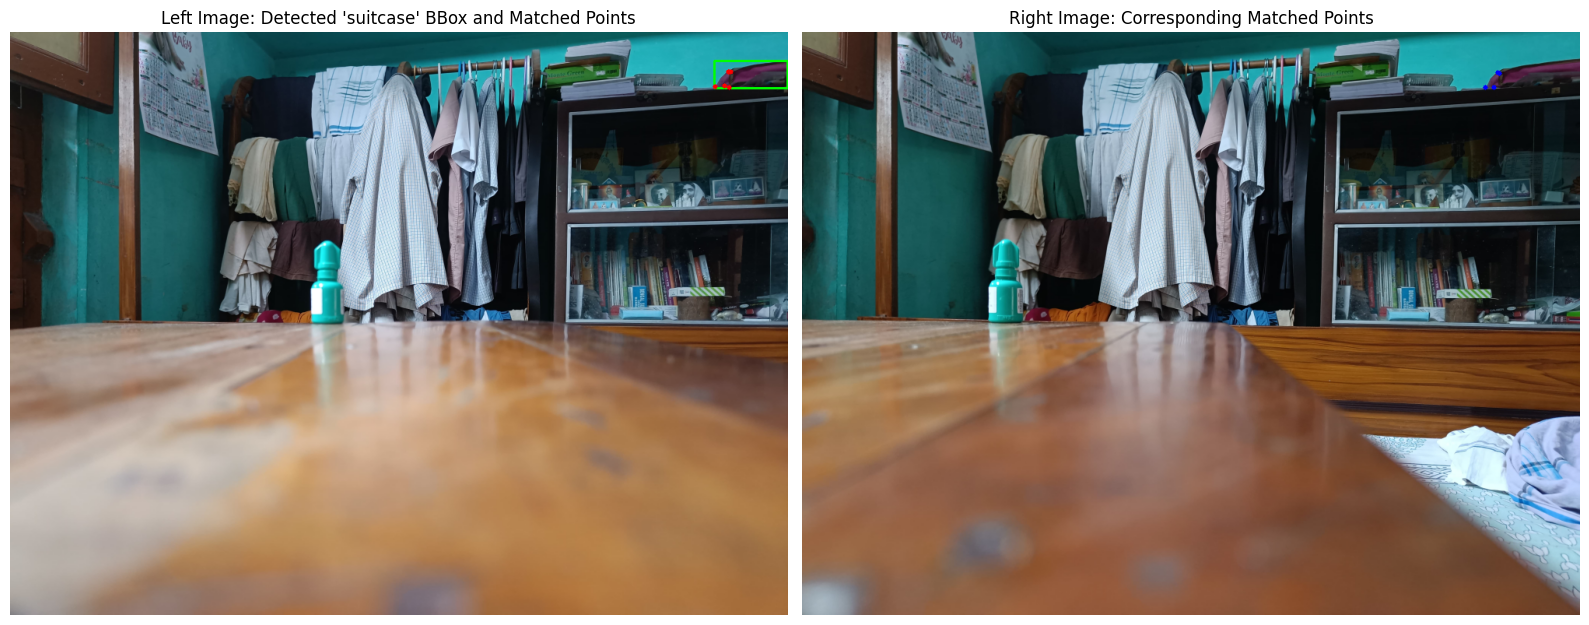

Calculated Disparity: 31.71 pixels
Estimated Distance to object: 198.66 cm
